In [691]:
# Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import yfinance as yf

In [692]:
# Lista com as ações da carteira
acoes = ['ITUB3.SA','BBDC4.SA','SANB11.SA','BBAS3.SA']

In [693]:
# Criando DF com as cotações usando Adj Close pelo yfinance
#df = pd.DataFrame()
#for i in acoes:
    #df[i] = yf.download(i, start='2021-01-01')['Adj Close']

In [694]:
# Mudando os nomes
#df = df.rename(columns={'ITUB3.SA':'ITUB','BBDC4.SA':'BBDC','SANB11.SA':'SANB','BBAS3.SA':'BB'})

In [695]:
# Salvando DF para evitar possíveis com yfinance
#df.to_csv('carteira.csv')
df=pd.read_csv('carteira.csv',index_col='Date')

In [696]:
# Descrição estatística dos dados
df.describe()

,ITUB,BBDC,SANB,BB
count,849.000000,849.000000,849.000000,849.000000
mean,21.539111,16.011222,28.357393,18.192689
std,3.232802,2.111236,2.411023,5.419674
min,16.380926,11.851674,23.675638,11.193896
25%,19.239979,14.101651,26.584587,13.500484
50%,20.896246,16.014410,28.163616,16.152300
75%,23.010231,17.573080,29.843475,22.913170
max,29.903021,21.962610,35.686741,29.474905


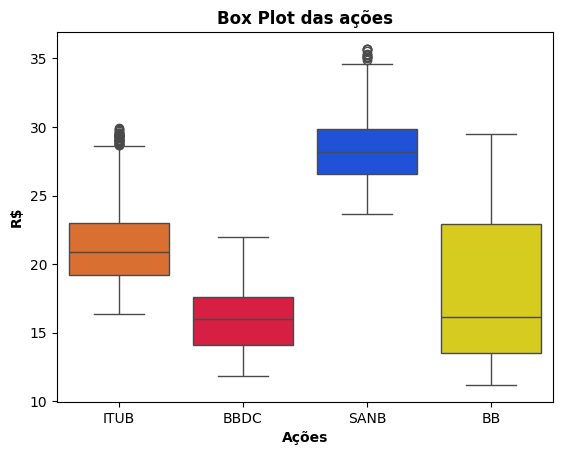

In [697]:
# Criando Box Plot para os papéis
cores=['#F56814','#F50031','#0045F5','#F5E600']
sns.boxplot(data=df,palette=cores)
plt.title('Box Plot das ações',fontweight='bold')
plt.xlabel('Ações',fontweight='bold')
plt.ylabel('R$',fontweight='bold')
plt.grid(False)
plt.show()

Durante o intervalo de tempo de 2021 até maio de 2024, o gráfico Box Plot e a descrição do df, destacam que o Banco do Brasil teve a maior variação dos preços de seus papéis, enquanto, os demais tiveram variação mais estáveis e próxima entre si.  

In [698]:
# Criando gráfico das cotações
figura = px.line(title = 'Histórico de cotações das ações')

for i, coluna in enumerate(df.columns):
    figura.add_scatter(x=df.index, y=df[coluna], name=coluna, line=dict(color=cores[i]))


figura.update_layout(
    xaxis_title='Data',
    yaxis_title='R$',
    title_x=0.5
)

figura.show()

O histórico das cotações indica que o Itaú e Banco do Brasil tiveram crescimento de seus valores de mercado, enquanto, que Santander e o Bradesco sofreram com quedas.

In [699]:
# Normalizando as cotações para melhor comparação dos retornos
df_normalizado = df.copy()
for i in df_normalizado.columns[0:]:
  df_normalizado[i] = df_normalizado[i] / df_normalizado[i][0];

In [700]:
# Criando gráfico das cotações normalizadas
figura = px.line(title = 'Histórico de cotações das ações (normalizado)')

for i, coluna in enumerate(df.columns):
    figura.add_scatter(x=df_normalizado.index, y=df_normalizado[coluna], name=coluna, line=dict(color=cores[i]))


figura.update_layout(
    xaxis_title='Data',
    yaxis_title='R$',
    title_x=0.5
)

figura.show()

Após a normalização, fica evidente que a maior variação da cotação do Banco do Brasil é explicada pelo seu grande crescimento comparado aos outros. Além disso, Itaú também obteve ganhos consideráveis, enquanto, Santander e Bradesco tiveram quedas. 

In [701]:
# Criando uma função para calcular a taxa de retorno simples
def txrs(acao,df):
    df[f'RS {acao}'] = (df[f'{acao}'] / df[f'{acao}'].shift(1)) - 1
    return df

In [702]:
# Aplicando a função para todas colunas
for coluna in df.columns[:len(df)]:
    df_txrs = df.copy()
    df_txrs = txrs(coluna, df)

df_txrs= df_txrs.dropna()

In [703]:
import sys

In [704]:
def alocacao_markowitz(df, capital, i, n):
  df = df.copy()
  df_original = df.copy()

  ls_txe = []
  ls_vole = []
  ls_sr = []

  melhor_sr = 1 - sys.maxsize
  melhores_p = np.empty
  melhor_vol = 0
  melhor_tx = 0

  for _ in range(n):
    pesos = np.random.random(len(df.columns)-1)
    pesos = pesos / pesos.sum()

    for w in df.columns[1:]:
      df[w] = df[w] / df[w][0]

    for w, k in enumerate(df.columns[1:]):
      df[k] = df[k] * pesos[w] * capital

    df.drop(labels = ['Date'], axis = 1, inplace=True)

    retorno_carteira = np.log(df / df.shift(1))
    matriz_cov = retorno_carteira.cov()

    df['soma valor'] = df.sum(axis = 1)
    df['taxa retorno'] = 0.0

    for w in range(1, len(df)):
      df['taxa retorno'][w] = np.log(df['soma valor'][w] / df['soma valor'][w - 1])

    retorno_esperado = np.sum(df['taxa retorno'].mean() * pesos) * 246
    vol_esperada = np.sqrt(np.dot(pesos, np.dot(matriz_cov * 246, pesos)))
    sharpe_ratio = (retorno_esperado - i) / vol_esperada

    if sharpe_ratio > melhor_sr:
      melhor_sr = sharpe_ratio
      melhores_p = pesos
      melhor_vol = vol_esperada
      melhor_tx = retorno_esperado

    ls_txe.append(retorno_esperado)
    ls_vole.append(vol_esperada)
    ls_sr.append(sharpe_ratio)

    df = df_original.copy()

  return melhor_sr, melhores_p, ls_txe, ls_vole, ls_sr, melhor_vol, melhor_tx

In [705]:
teste = pd.read_csv('carteira.csv')

In [706]:
import warnings
warnings.filterwarnings("ignore")
melhor_sharpe_ratio, melhores_pesos, lista_retorno_esperado, lista_volatilidade_esperada, lista_sharpe_ratio, melhor_volatilidade, melhor_retorno = alocacao_markowitz(teste, 5000, 5 / 100, 100);

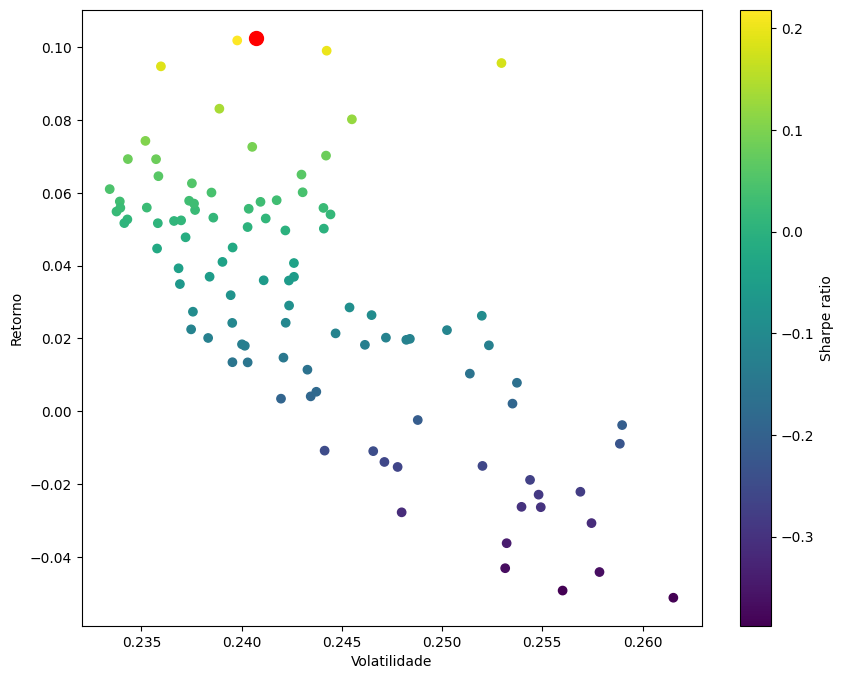

In [707]:
plt.figure(figsize=(10,8))
plt.scatter(lista_volatilidade_esperada, lista_retorno_esperado, c = lista_sharpe_ratio)
plt.colorbar(label = 'Sharpe ratio')
plt.xlabel('Volatilidade')
plt.ylabel('Retorno')
plt.scatter(melhor_volatilidade, melhor_retorno, c = 'red', s = 100);